# CE802 

In [428]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
%matplotlib inline

## Import Data

In [530]:
# importing data from csv file as data
data = pd.read_csv("CE802_Ass_2019_Data.csv")
data.head(n=3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F12,F13,F14,F15,F16,F17,F18,F19,F20,Class
0,0,0,16,2.02,0.52,-2.35,-1.98,-0.70,85,6,...,-0.07,1.08,15,-0.63,-3.49,-1.68,0.02,15.3,NaN,True
1,0,0,86,-0.90,2.75,0.14,0.83,-0.06,107,1,...,0.17,1.06,-8,-1.21,0.34,0.36,0.61,10.1,NaN,True
2,1,1,165,0.73,1.05,0.10,2.57,-1.65,41,5,...,0.04,0.42,-6,-0.46,-0.62,1.67,2.60,11.0,1.55,False


## Data Analysis

In [531]:
# summarty statistics for the data (data analysis)
data.drop(columns = ['Class']).describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,328.000000
mean,0.668000,0.506000,93.20400,-0.065980,-0.037800,0.03994,1.219340,-0.046900,38.352000,7.156000,-0.000580,-0.004480,0.936420,0.742000,0.004500,0.385840,-0.073300,-0.083320,9.294200,0.074146
std,0.471403,0.500465,70.32064,1.534023,1.041526,1.04141,1.372958,0.980714,25.331946,16.716295,1.076134,1.014567,0.702435,15.458634,0.982961,1.645632,0.979986,0.999405,5.813214,1.891396
min,0.000000,0.000000,3.00000,-4.300000,-2.870000,-2.90000,-2.330000,-3.230000,0.000000,-49.000000,-3.470000,-3.570000,0.000000,-41.000000,-3.240000,-4.080000,-3.060000,-3.190000,0.500000,-5.350000
25%,0.000000,0.000000,37.00000,-1.102500,-0.792500,-0.67000,0.297500,-0.690000,18.000000,-5.000000,-0.750000,-0.702500,0.347500,-9.250000,-0.615000,-0.802500,-0.730000,-0.742500,5.100000,-0.740000
50%,1.000000,1.000000,79.00000,-0.105000,-0.030000,0.03000,1.235000,-0.080000,35.000000,7.000000,0.010000,0.025000,0.790000,0.000000,-0.005000,0.385000,-0.120000,-0.100000,8.200000,0.170000
75%,1.000000,1.000000,135.25000,1.042500,0.640000,0.76000,2.080000,0.592500,54.000000,19.000000,0.792500,0.680000,1.335000,12.000000,0.662500,1.505000,0.560000,0.602500,11.800000,0.910000
max,1.000000,1.000000,338.00000,3.900000,3.300000,3.22000,5.690000,2.700000,140.000000,61.000000,3.900000,3.030000,4.000000,55.000000,3.260000,5.680000,2.620000,3.640000,36.800000,6.130000


False    279
True     221
Name: Class, dtype: int64


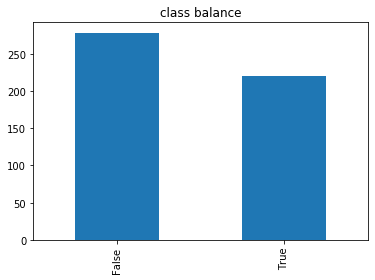

In [532]:
# check class balance (data analysis)
print(data.Class.value_counts())
data.Class.value_counts().plot(kind = 'bar', title = 'class balance')

## Pruned Decision Tree 

In [539]:
### See https://medium.com/@haydar_ai/learning-data-science-day-22-cross-validation-and-parameter-tuning-b14bcbc6b012

def Build_tree(x,y):
    clf = DecisionTreeClassifier(random_state = 42)   
    path = clf.cost_complexity_pruning_path(x, y) 
    ccp_alphas = np.ndarray.tolist(path.ccp_alphas)                                                        
    max_depth = list(range(1,30,1))     
    parameter_grid = {'ccp_alpha':ccp_alphas,
                      'criterion': ['gini', 'entropy'],
                      'splitter': ['best', 'random'],
                      'max_depth': max_depth }
    cross_validation = StratifiedKFold(n_splits=10) 
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=cross_validation, n_jobs = -1) 
    grid_search.fit(x,y)                           
    print('Average Accuracy of the model: {}'.format(grid_search.best_score_))  
    print('Best parameters: {}'.format(grid_search.best_params_))
    clf = grid_search.best_estimator_              
    return clf


##### Building pruned decision tree 'without F20 feature'


In [540]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df = df.drop(columns = ['F20'])                       # remove the attribute F20 from the data 
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

#'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

in_data = x_norm
target = y_smt

print(Build_tree.__doc__)
Build_tree(in_data,target)

None
Average Accuracy of the model: 0.6578231292517006
Best parameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 16, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=16, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='random')

##### Building pruned decision tree with 'mean imputation'

In [492]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.mean(), inplace=True)              # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

print(Build_tree.__doc__)
Build_tree(x,y)

None
Average Accuracy of the model: 0.675
Best parameters: {'ccp_alpha': 0.003125, 'criterion': 'gini', 'max_depth': 13, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.003125, class_weight=None, criterion='gini',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='random')

##### Building pruned decision tree with 'median imputation'

In [493]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.median(), inplace=True)            # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

print(Build_tree.__doc__)
Build_tree(x,y)

None
Average Accuracy of the model: 0.6729166666666666
Best parameters: {'ccp_alpha': 0.003125, 'criterion': 'gini', 'max_depth': 19, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.003125, class_weight=None, criterion='gini',
                       max_depth=19, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='random')

##### Building pruned decision tree with iterative imputer 

In [491]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
imp = IterativeImputer(max_iter= 10, random_state= 42)  # iterative imputer  https://scikit-learn.org/stable/modules/impute.html#iterative-imputer
x = imp.fit_transform(df.values)                      # select feature to input to the classifier
x = pd.DataFrame(x).drop(columns = [20])              # output to the classifier
y = df.Class
                                 

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

print(Build_tree.__doc__)
Build_tree(x,y)

None
Average Accuracy of the model: 0.6833333333333333
Best parameters: {'ccp_alpha': 0.006128625472887766, 'criterion': 'gini', 'max_depth': 13, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.006128625472887766, class_weight=None,
                       criterion='gini', max_depth=13, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42,
                       splitter='random')

##### Building pruned decision tree with 'KNN imputation' k = int(sqrt(n))

In [494]:
df = data.copy()
x = int(math.sqrt(df.F20.count()))
imputer = KNNImputer(n_neighbors = x, weights = 'distance')
x = imputer.fit_transform(df.values)
x = pd.DataFrame(x).drop(columns = [20])
y = df.Class

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

print(Build_tree.__doc__)
Build_tree(x,y)

None
Average Accuracy of the model: 0.6875
Best parameters: {'ccp_alpha': 0.0037037037037037034, 'criterion': 'gini', 'max_depth': 14, 'splitter': 'random'}


DecisionTreeClassifier(ccp_alpha=0.0037037037037037034, class_weight=None,
                       criterion='gini', max_depth=14, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42,
                       splitter='random')

## Logistic Regression

In [292]:
def logistic_classifier (x,y):
    
    clf = LogisticRegression(random_state = 42)        
    parameter_grid = { 'penalty':['l1','l2','elasticnet','none'],
                       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga' ],
                       'C':[0,0.1,0.5,1,10] }
    cross_validation = StratifiedKFold(n_splits=10)                                
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=cross_validation, n_jobs = -1) 
    grid_search.fit(x,y)                                                          
    print('Average Accuracy of the model: {}'.format(grid_search.best_score_))  
    print('Best parameters: {}'.format(grid_search.best_params_))
    clf = grid_search.best_estimator_                                              



###### No F20 feature

In [274]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df = df.drop(columns = ['F20'])                       # remove the attribute F20 from the data 
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

logistic_classifier(x,y)

Average Accuracy of the model: 0.5682397959183673
Best parameters: {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'}


##### Mean Imputation 

In [276]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.mean(), inplace=True)              # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

logistic_classifier(x,y)

Average Accuracy of the model: 0.6270833333333333
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


##### Median Imputation

In [277]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.median(), inplace=True)            # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

logistic_classifier(x,y)

Average Accuracy of the model: 0.6333333333333332
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


##### Iterative Imputer

In [293]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
imp = IterativeImputer(max_iter=10, random_state= 42) # iterative imputer  https://scikit-learn.org/stable/modules/impute.html#iterative-imputer
x = imp.fit_transform(df.values)                      # select feature to input to the classifier
x = pd.DataFrame(x).drop(columns = [20])              # output to the classifier
y = df.Class
                                 

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

logistic_classifier(x,y)

Average Accuracy of the model: 0.8458333333333334
Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


C:\Users\myema\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##### KNN Imputer

In [294]:
df = data.copy()
x = int(math.sqrt(df.F20.count()))
imputer = KNNImputer(n_neighbors = x, weights = 'distance')
x = imputer.fit_transform(df.values)
x = pd.DataFrame(x).drop(columns = [20])
y = df.Class

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

logistic_classifier(x,y)

Average Accuracy of the model: 0.6354166666666666
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


## Naive Bayes

In [319]:
def NaiveBayes (x,y):
    
    clf = GaussianNB() 
    clf.fit(x,y)
    score = cross_val_score(clf,x,y,cv = 10)
    print('Average Accuracy of the model: {}'.format(np.mean(score)))  

###### No F20 feature

In [320]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df = df.drop(columns = ['F20'])                       # remove the attribute F20 from the data 
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

NaiveBayes(x,y)

Average Accuracy of the model: 0.5728316326530613


##### Mean Imputation 

In [312]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.mean(), inplace=True)              # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

NaiveBayes(x,y)

Average Accuracy of the model: 0.5604166666666667


##### Median Imputation

In [313]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.median(), inplace=True)            # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

NaiveBayes(x,y)

Average Accuracy of the model: 0.5645833333333333


##### Iterative Imputer

In [315]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
imp = IterativeImputer(max_iter=10, random_state= 42) # iterative imputer  https://scikit-learn.org/stable/modules/impute.html#iterative-imputer
x = imp.fit_transform(df.values)                      # select feature to input to the classifier
x = pd.DataFrame(x).drop(columns = [20])              # output to the classifier
y = df.Class
                                 

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

NaiveBayes(x,y)

Average Accuracy of the model: 0.58125


##### KNN Imputer

In [316]:
df = data.copy()
x = int(math.sqrt(df.F20.count()))
imputer = KNNImputer(n_neighbors = x, weights = 'distance')
x = imputer.fit_transform(df.values)
x = pd.DataFrame(x).drop(columns = [20])
y = df.Class

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

NaiveBayes(x,y)

Average Accuracy of the model: 0.5583333333333333


## Support Vector Machine

In [328]:
def svm_(x,y):
    clf = svm.SVC (random_state = 42)        
    parameter_grid = { 'C':[2**-5,2**-3,2**-1,2**1,2**3,2**5,2**7,2**9,2**11,2**13,2**15],
                       'gamma':[2**15,2**13,2**11,2**9,2**7,2**5,2**3,2**1,2**-1,2**-3,2**-5],
                       'kernel':['linear','poly','rbf','sigmoid'] }
    cross_validation = StratifiedKFold(n_splits=10)                                
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=cross_validation, n_jobs = -1) 
    grid_search.fit(x,y)                                                          
    print('Average Accuracy of the model: {}'.format(grid_search.best_score_))  
    print('Best parameters: {}'.format(grid_search.best_params_))
    clf = grid_search.best_estimator_  

###### No F20 feature

In [329]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df = df.drop(columns = ['F20'])                       # remove the attribute F20 from the data 
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

svm_(x,y)

Average Accuracy of the model: 0.7386479591836734
Best parameters: {'C': 128, 'gamma': 0.5, 'kernel': 'rbf'}


##### Mean Imputation 

In [330]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.mean(), inplace=True)              # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

svm_(x,y)

Average Accuracy of the model: 0.75625
Best parameters: {'C': 512, 'gamma': 0.5, 'kernel': 'rbf'}


##### Median Imputation

In [331]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.median(), inplace=True)            # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

svm_(x,y)

Average Accuracy of the model: 0.7562499999999999
Best parameters: {'C': 128, 'gamma': 0.5, 'kernel': 'rbf'}


##### Iterative Imputer

In [332]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
imp = IterativeImputer(max_iter=10, random_state= 42) # iterative imputer  https://scikit-learn.org/stable/modules/impute.html#iterative-imputer
x = imp.fit_transform(df.values)                      # select feature to input to the classifier
x = pd.DataFrame(x).drop(columns = [20])              # output to the classifier
y = df.Class
                                 

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

svm_(x,y)

Average Accuracy of the model: 0.8583333333333332
Best parameters: {'C': 512, 'gamma': 0.03125, 'kernel': 'rbf'}


##### KNN Imputer

In [333]:
df = data.copy()
x = int(math.sqrt(df.F20.count()))
imputer = KNNImputer(n_neighbors = x, weights = 'distance')
x = imputer.fit_transform(df.values)
x = pd.DataFrame(x).drop(columns = [20])
y = df.Class

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

svm_(x,y)

Average Accuracy of the model: 0.7520833333333333
Best parameters: {'C': 128, 'gamma': 0.5, 'kernel': 'rbf'}


## K-NN

In [364]:
def KNN(x,y):
    
    clf = KNeighborsClassifier(n_jobs = -1)  
    k_range = range(1, 31)
    weight_options = ['uniform', 'distance']
    parameter_grid =  {'n_neighbors': k_range,'weights': weight_options}
    cross_validation = StratifiedKFold(n_splits=10)                                
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=cross_validation, n_jobs = -1) 
    grid_search.fit(x,y) 
    print('Average Accuracy of the model: {}'.format(grid_search.best_score_))  
    print('Best parameters: {}'.format(grid_search.best_params_))
    clf = grid_search.best_estimator_  
    

###### No F20 feature

In [365]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df = df.drop(columns = ['F20'])                       # remove the attribute F20 from the data 
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

KNN(x,y)

Average Accuracy of the model: 0.647236394557823
Best parameters: {'n_neighbors': 4, 'weights': 'distance'}


##### Mean Imputation 

In [366]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.mean(), inplace=True)              # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

KNN(x,y)

Average Accuracy of the model: 0.6395833333333332
Best parameters: {'n_neighbors': 4, 'weights': 'distance'}


##### Median Imputation

In [367]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
df.fillna(data.F20.median(), inplace=True)            # replace all the NaN values in F20 feautre with the mean of the F20 Feature
x = df.drop(columns=['Class'])                        # select all attributes except class as input to the classifier
y = df.Class                                          # select Class as output to the classifier

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

KNN(x,y)

Average Accuracy of the model: 0.6375
Best parameters: {'n_neighbors': 4, 'weights': 'distance'}


##### Iterative Imputer

In [368]:
df = data.copy()                                      # create new dataframe from the original data for preprocessing     
imp = IterativeImputer(max_iter=10, random_state= 42) # iterative imputer  https://scikit-learn.org/stable/modules/impute.html#iterative-imputer
x = imp.fit_transform(df.values)                      # select feature to input to the classifier
x = pd.DataFrame(x).drop(columns = [20])              # output to the classifier
y = df.Class
                                 

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

KNN(x,y)

Average Accuracy of the model: 0.6791666666666666
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}


##### KNN Imputer

In [369]:
df = data.copy()
x = int(math.sqrt(df.F20.count()))
imputer = KNNImputer(n_neighbors = x, weights = 'distance')
x = imputer.fit_transform(df.values)
x = pd.DataFrame(x).drop(columns = [20])
y = df.Class

''' using SMOTE-Tomek method to aritifically generate new data
    so that the data is not skewed towards one class '''

smt = SMOTETomek(random_state = 42)                   # fixing random state for reproducibility of the model
X_smt, y_smt = smt.fit_sample(x, y) 

'Normalise the data between 0 and 1'
x_norm = X_smt.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis = 0)

x = x_norm
y = y_smt

KNN(x,y)

Average Accuracy of the model: 0.6770833333333333
Best parameters: {'n_neighbors': 4, 'weights': 'distance'}
